In [1]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pathToHistory = '/content/gdrive/MyDrive/sets/'
optimizer = Adam(0.0002, 0.5)
loss = 'binary_crossentropy'
loss_g = 'msle'  # 'mse', 'poisson', 'binary_crossentropy'
epochs = 5001  # Число эпох обучения на пакете
batch_size = 128  # Размер пакета обучения (число генерируемых изображений)
sample_interval = 500  # Интервал между сохранением сгенерированных изображений в файл
show_sum = not False
file_gen = pathToHistory + 'generator_model_%03d.h5' % epochs
print('epochs =', epochs, '\ batch_size =', batch_size)

epochs = 5001 \ batch_size = 128


In [5]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
x_train = x_train[y_train == 8]
x_test = x_test[y_test == 8]

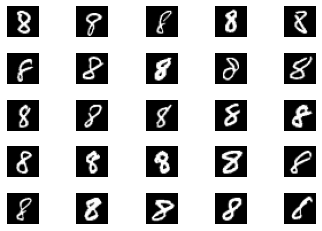

In [ ]:
r = c = 5
for i, j in enumerate(np.random.randint(0, len(x_train), r * c)):
     plt.subplot(r, c, i + 1)
     plt.imshow(x_train[j], cmap='gray')
     plt.axis('off')
plt.subplots_adjust(hspace=0.5)  # wspace
plt.show()

In [7]:
x_train = x_train / 255
x_test = x_test / 255

In [8]:
x_reversed = np.abs(x_train - 1)

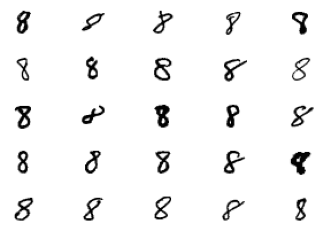

In [ ]:
for i, j in enumerate(np.random.randint(0, len(x_reversed), r * c)):
     plt.subplot(r, c, i + 1)
     plt.imshow(x_reversed[j], cmap = 'gray')
     plt.axis('off')
plt.subplots_adjust(hspace=0.5)  # wspace
plt.show()

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_reversed = x_reversed.astype('float32')

In [ ]:
x_train.shape

(5851, 28, 28)

In [ ]:
x_test.shape

(974, 28, 28)

In [10]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
x_reversed = x_reversed.reshape(x_reversed.shape[0], 784)

In [11]:
def m_inp(x, x_r, b_s):  # Вход дискриминатора и генератора
    idx = np.random.randint(0, x.shape[0], b_s)
    d_n = x_r[idx]
    g_n = x[idx]
    return d_n, g_n

In [ ]:
def one_dense(units, x):
    x = Dense(units)(x)
    x = LeakyReLU()(x)
    return Dropout(0.25)(x)

In [ ]:
def one_dense2(x, units, a):
    x = Dense(units)(x)
    x = LeakyReLU(alpha=a)(x)
    return x

In [ ]:
def build_generator():
    inp = Input(shape = (784, ))
    x = one_dense(512, inp)
    x = one_dense(256, x)
    x = one_dense(128, x)
    x = one_dense(64, x)
    x = Dense(32)(x)
    encoded = LeakyReLU()(x)
    x = one_dense(64, encoded)
    x = one_dense(128, x)
    x = one_dense(256, x)
    x = one_dense(512, x)
    decoded = Dense(784, activation = 'sigmoid')(x)
    generator = Model(inp, decoded)
    if show_sum:
        generator.summary()
    return generator

In [ ]:
def build_discriminator(loss, optimizer):
    inp = Input(784)
    x = inp
    x = one_dense2(x, 512, 0.2)
    x = one_dense2(x, 256, 0.2)
    out = Dense(1, activation='sigmoid')(x)
    discriminator = Model(inp, out)
    if show_sum:
        discriminator.summary()
    discriminator.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return discriminator

In [ ]:
def train(discriminator, generator, combined, epochs, b_s,
          sample_interval, pathToHistory, x_trn, x_rvr):
    # Метки истинных и ложных изображений
    valid = np.ones(b_s)
    d_loss, d_acc, g_loss, g_acc = [], [], [], []
    for epoch in range(epochs):
        # Обучаем дискриминатор
        d_n, g_n = m_inp(x_trn, x_rvr, b_s)  # Вход дискриминатора (d_n) и генератора (g_n)
        gen_imgs = generator.predict(g_n)  # Генерируем batch_size изображений
        # Обучаем дискриминатор, подавая ему сначала настоящие, а затем поддельные изображения
        d_hist_real = discriminator.train_on_batch(d_n, valid)
        d_hist_fake = discriminator.train_on_batch(gen_imgs, valid - 1)
        # Усредняем результаты и получаем средние потери и точность
        d_ls, d_a = 0.5 * np.add(d_hist_real, d_hist_fake)
        # Обучение обобщенной модели. Реально обучается только генератор
        _, g_n = m_inp(x_trn, x_rvr, b_s)
        g_ls, g_a = combined.train_on_batch(g_n, valid)
        if epoch % 100 == 0:
            d_loss.append(d_ls)
            d_acc.append(d_a)
            g_loss.append(g_ls)
            g_acc.append(g_a)
        # Потери и точность дискриминатора и потери генератора
        if epoch % (sample_interval / 5) == 0:
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]"
                  % (epoch, d_ls, 100 * d_a, g_ls, 100 * g_a))
        # Генерируем и сохраняем рисунок с 25-ю изображениями
        if epoch % sample_interval == 0:
            save_sample_images(generator, epoch, x_trn, x_rvr)
    # Сохраняем обученный генератор в файл
    generator.compile()
    generator.save(file_gen)
    print('Модель генератора сохранена в файл', file_gen)
    # Вывод историй обучения в файлы
    fn_d_loss, fn_d_acc, fn_g_loss = 'd_loss.txt', 'd_acc.txt', 'g_loss.txt'
    print('Истории сохранены в файлы:\n' + fn_d_loss + '\n' + fn_d_acc + '\n' + fn_g_loss)
    with open(pathToHistory + fn_d_loss, 'w') as output:
        for val in d_loss:
            output.write(str(val) + '\n')
    with open(pathToHistory + fn_d_acc, 'w') as output:
        for val in d_acc:
            output.write(str(val) + '\n')
    with open(pathToHistory + fn_g_loss, 'w') as output:
        for val in g_loss:
            output.write(str(val) + '\n')
    # Вывод графиков историй обучения
    print('Вывод графиков историй обучения')
    yMax = max(g_loss)
    cnt = len(g_loss)
    rng = np.arange(cnt)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(rng, d_loss, marker='o', c='blue', edgecolor='black')
    ax.scatter(rng, g_loss, marker='x', c='red')
    ax.set_title('Потери генератора (x) и дискриминатора (o)')
    ax.set_ylabel('Потери')
    ax.set_xlabel('Эпоха / 100')
    ax.set_xlim([-0.5, cnt])
    ax.set_ylim([0, 1.1 * yMax])
    fig.show()
    yMin = min(d_acc)
    cnt = len(d_acc)
    rng = np.arange(cnt)
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(rng, d_acc, marker='o', c='blue', edgecolor='black')
    ax.scatter(rng, g_acc, marker='x', c='red')
    ax.set_title('Точность генератора (x) и дискриминатора (o)')
    ax.set_ylabel('Точность')
    ax.set_xlabel('Эпоха / 100')
    ax.set_xlim([-0.5, cnt])
    ax.set_ylim([0.95 * yMin, 1.0])
    fig.show()

In [12]:
def save_sample_images(generator, epoch, x_trn, x_rvr):
    r, c = 5, 5  # Выводим и сохраняем 25 изображений
    _, g_n = m_inp(x_trn, x_rvr, r * c)
    gen_imgs = generator.predict(g_n)
    # Возвращаемся к диапазону [0, 1]
    # gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt].reshape(28, 28), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    # cnt = 0        
    # for i in range(r):
    #     for j in range(c):
    #         axs[i, j].imshow(g_n[cnt].reshape(28, 28), cmap='gray')
    #         axs[i, j].axis('off')
    #         cnt += 1
    # Сохраняем изображения
    # fig.savefig(pathToHistory + '%d.png' % epoch)
    # plt.close()
    # plt.show()

In [ ]:
generator = build_generator()  # Генератор
discriminator = build_discriminator(loss, optimizer)  # Дискриминатор (c компиляцией)
# Обобщенная модель
inp = Input(shape = (784, ))
x = generator(inp)
discriminator.trainable = False
out = discriminator(x)
combined = Model(inp, out)
combined.compile(loss=loss_g, optimizer=optimizer, metrics=['accuracy'])
if show_sum:
    combined.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0     

Обучение. Интервал между выводом изображений  500
0 [D loss: 1.163787, acc.: 26.17%] [G loss: 0.023129, acc.: 100.00%]
100 [D loss: 0.709557, acc.: 50.00%] [G loss: 0.076977, acc.: 84.38%]
200 [D loss: 0.707663, acc.: 49.61%] [G loss: 0.078855, acc.: 84.38%]
300 [D loss: 0.706356, acc.: 49.61%] [G loss: 0.088990, acc.: 23.44%]
400 [D loss: 0.691668, acc.: 50.00%] [G loss: 0.096527, acc.: 0.00%]
500 [D loss: 0.700078, acc.: 44.92%] [G loss: 0.114698, acc.: 0.00%]
600 [D loss: 0.742915, acc.: 17.19%] [G loss: 0.117440, acc.: 0.00%]
700 [D loss: 0.742356, acc.: 26.95%] [G loss: 0.094428, acc.: 0.78%]
800 [D loss: 0.696151, acc.: 33.98%] [G loss: 0.110240, acc.: 6.25%]
900 [D loss: 0.634152, acc.: 88.28%] [G loss: 0.118386, acc.: 0.00%]
1000 [D loss: 0.644300, acc.: 80.86%] [G loss: 0.169508, acc.: 0.00%]
1100 [D loss: 0.489106, acc.: 93.36%] [G loss: 0.161665, acc.: 14.06%]
1200 [D loss: 1.088088, acc.: 12.50%] [G loss: 0.136387, acc.: 6.25%]
1300 [D loss: 0.513359, acc.: 94.92%] [G loss:

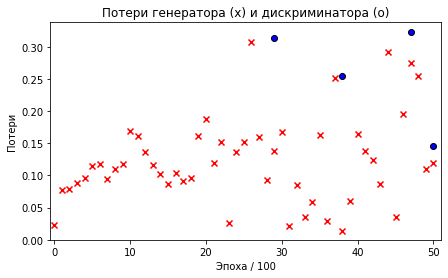

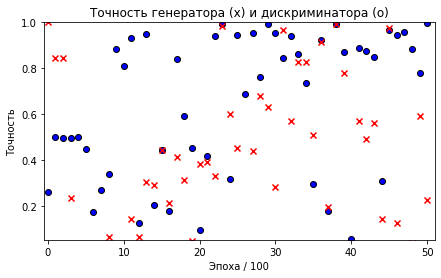

In [ ]:
print('Обучение. Интервал между выводом изображений ', sample_interval)
train(discriminator, generator, combined, epochs,
      batch_size, sample_interval, pathToHistory, x_train, x_reversed)

In [13]:
from keras.models import load_model

In [14]:
print('Загрузка модели из файла ', file_gen)
generator = load_model(file_gen)

Загрузка модели из файла  /content/gdrive/MyDrive/sets/generator_model_5001.h5


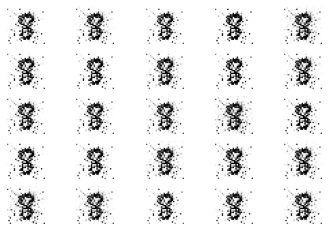

In [15]:
# сгнерированные на проверочной выборке изображения в файл
save_sample_images(generator, 123456789, x_test, x_reversed)